### Encode stimulus onset into spike trains using a Poisson GLM
##### Tanvi Ranjan
In a recent paper by [Steinmetz et al 2019](https://www.nature.com/articles/s41586-019-1787-x), the authors recorded neural activity from a mouse brain during a decision-making task. On each trial, a left and right image, of different contrasts, was shown to the animal, and the animal was rewarded if it moved the wheel to bring the higher contrast image to the center of the workspace. The following schematic shows the trial sequence
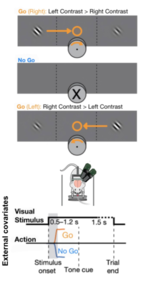


Neural activity was recorded from different brain regions. In a broader project, we build models to determine which neurons encode the stimulus and action as a function of their spiking rate. In order to realise that aim, in this part of the project, I build a Poisson Generalized Linear Model (GLM) to determine which brain regions have high activity in response to stimulus and action. Thereafter, in the [subsequent part of the project](https://docs.google.com/presentation/d/1-oodRn4CP0bmEJ06mS4SYqmD3fQw9Kd3mScViA7F3JI/edit#slide=id.g9c73cc23b5_0_0), we use those specific brain regions to predict stimulus and action from neural activity

#### Methods:
Poisson GLM ([Neuromatch slides]()) has been used to decode stimulus and/or action from neural activity in many datasets ([example-1](), [example-2]()). Here, we apply this method to the dataset from Steinmetz et al, '19 in a decision making task. The aim of this project part is to determine which brain regions might be useful in decoding task parameters (stimulus and action).

To fit a Poisson GLM, we follow the following steps:
* Created predictor variables = stimulus on trial $t$ to $t-d$, where d is a parameter
* Used the exponential link function to predict rate
* Minimized negative log likelihood to predict coupling weights for the predictor variables in order to predit neural firing rate 

#### Results and future work
* We see that with 10 history points, the coupling of neural activity to predict visual stimulus is strongest in the visual cortex, whereas the coupling to predict action is stronges in the mid-brain. Unsurpring, but good to check it with this model

* In our [full project](https://docs.google.com/presentation/d/1-oodRn4CP0bmEJ06mS4SYqmD3fQw9Kd3mScViA7F3JI/edit#slide=id.g9c73cc23b5_0_0) use mid-brain to predict action and visual cortex to predict stimulus


In [15]:
#pip install spykes
import pdb
from scipy.optimize import minimize
from importlib import reload
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import numpy as np
import deps
from scipy import stats

from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")


#matplotlib settings
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

get data
convert raster
make dataframe
get spike times


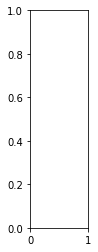

In [10]:
# HIDE CELL

reload(deps)

alldat, dat_LFP, dat_ST = deps.get_data(); print('get data')
dat = alldat[11]
sp, neu, trial_starts = deps.convert_raster_to_spiketimes(dat); print('convert raster')
events_df = deps.convert_events_to_dataframe(dat, trial_starts,
                                             event_names=('gocue', 'response_time','feedback_time'),
                                             condition_names=('response','contrast_right','contrast_left','feedback_type'))
print('make dataframe')
spykes_times = deps.spykes_get_times(sp, neu)

print('get spike times')
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high

#### Visualize the stimulus
Let's start with visualizing the contrast difference between the left and right stimuli. We encode the contrast difference as {-1, 0, +1}
* If contrast of left stimuli is higher, contrast difference is +1
* If contrast or right stimuli is higher, contrast difference is -1 
* If both left and right stimuli have same contrast, the contrast difference is 0

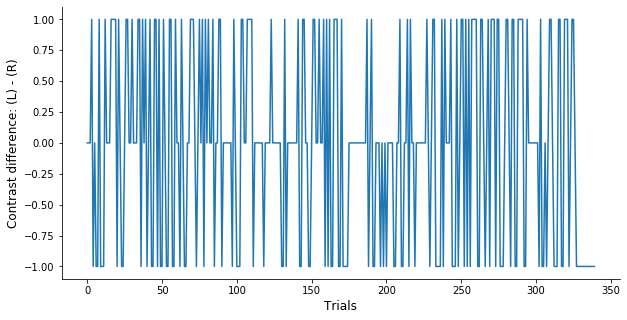

In [11]:
#Make contrast matrix
import seaborn as sns

cL = dat['contrast_left']; cR = dat['contrast_right']
cdiff = np.empty_like(cL)

for i in range(len(cL)):
    cdiff[i] = 1*(cL[i]>cR[i]) + (-1)*(cL[i] < cR[i]) + 0*(cL[i] == cR[i])

f=plt.figure(figsize=(10,5))
plt.plot(cdiff); plt.xlabel('Trials'); plt.ylabel('Contrast difference: (L) - (R)'); 
sns.despine()
plt.show()

In [12]:
'''
Functions to make the poisson GLM
1. Make stimulus design matrix
2. Calculate negative log-likelihood
3. Fit parameters that minimize -ve log likelihood with L1 penalty
4. After fitting predict the spike counts
'''

def make_design_matrix(stim,d):
    try:
        padded_stim = np.concatenate([np.zeros(d - 1), stim])
    except:
        print('Error hath arisen')
        pdb.set_trace()
    T = len(stim)  # Total number of trials
    X = np.zeros((T, d))
    for t in range(T):
        X[t] = padded_stim[t:t+d]

    return X
    
def neg_log_like(theta,X,y,L1_penalty):
#      Args:
#     theta (1D array): Parameter vector.
#     X (2D array): Full design matrix.
#     y (1D array): Data values. Number of spikes for each trial
    
    rate = np.exp(X @ theta)
    penalty = L1_penalty*np.sum((theta)**2) #20*np.sum(np.abs(theta))
    LL = y @ np.log(rate) - np.ones_like(y) @ rate
    log_lik = LL - penalty
#     print(f' LL: {LL:1.3f}, L1: {penalty:1.3f}, log_lik: {log_lik:1.3f}')
    return -log_lik

def fit_lnp(stim,dummy,spikes,d,L1_penalty):
    y = spikes
    constant = np.ones_like(y)
    
#     pdb.set_trace()
    X = np.column_stack([constant, dummy, make_design_matrix(stim,d)])

    # Use a random vector of weights to start (mean 0, sd .2)
    theta0 = np.random.normal(0, .2, np.size(X[0]))  #d + 1)

    # Find parameters that minmize the negative log likelihood function
    res = minimize(neg_log_like, theta0, args=(X, y,L1_penalty))

    return res["x"]

def predict_spike_counts_lnp(stim,dummy,spikes,d,L1_penalty,theta=None):
    y = spikes
    constant = np.ones_like(spikes)

    if theta is None:
        theta = fit_lnp(stim,dummy,y,d,L1_penalty)
    
    #Make X again to compute predicted spikes
    X = np.column_stack([constant, dummy, make_design_matrix(stim,d)])
    yhat = np.exp(X @ theta)
    return yhat, theta



Next, we calculate the total number of spikes for each neuron in each trial. We only take the time slice after stimulus presentation and before go-cue. Stimulus presentation is at 0.5 s and on-average the go-cue starts at 1.3s (so indices are 50:131)

In [13]:
all_spikes = np.transpose(np.sum(dat['spks'][:,:,50:131],axis=2)); 
#print(all_spikes.shape)

#### (Side): What are firing rates of neurons?

Let's visualize the total number of spikes in neurons of the visual cortex and then choose the neurons whose mean firint rates across all trials is > 5 spikes

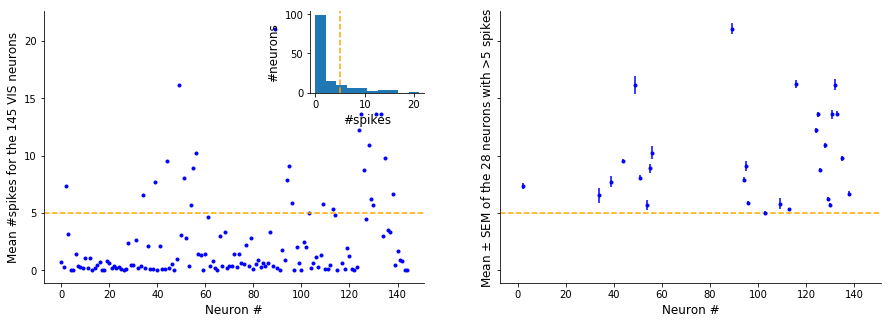

In [18]:
#Visualize vis-ctx neurons' firing rates
idx_vis = np.char.startswith(dat['brain_area'],'VIS',start=0,end=None)
vis_neurons = np.where(idx_vis)[0]

#Find neurons with high-ish spike rates and try to encode
vis_spikes = all_spikes[:,vis_neurons] #print(vis_spikes.shape)
f,ax = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
mean_vis_spikes, sem_vis_spikes = np.mean(vis_spikes,axis=0), stats.sem(vis_spikes,axis=0)
ax[0].plot(mean_vis_spikes,'.b'); 
ax[0].set_ylabel(f'Mean #spikes for the {len(vis_neurons):d} VIS neurons')
ax[0].set_xlabel('Neuron #')

#Pick neurons with a threshold firing rate/spike number
spike_thresh = 5
ax[0].axhline(spike_thresh, xmin=0, xmax=len(mean_vis_spikes),ls='--',color='orange')
idx_high = np.where(mean_vis_spikes>spike_thresh)[0]
vis_neurons_thresh = vis_neurons[idx_high]

#print(f'OG indices of neurons with min {spike_thresh:d} spikes'); print(vis_neurons_thresh) # to keep track of which original neuron

ax[1].errorbar(idx_high, mean_vis_spikes[idx_high], sem_vis_spikes[idx_high],fmt='.',color='blue'); 
ax[1].axhline(spike_thresh, xmin=0, xmax=len(mean_vis_spikes),ls='--',color='orange')
ax[1].set_xlabel('Neuron #'); 
ax[1].set_ylabel(f'Mean $\pm$ SEM of the {len(idx_high)} neurons with >{spike_thresh} spikes')
sns.despine()

# Inset - make histogram
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax[0], [0.7,0.7,0.3,0.3])
ax2.set_axes_locator(ip);
ax2.hist(mean_vis_spikes); ax2.axvline(spike_thresh,ymin=0,ymax=300,ls='--',color='orange')
ax2.set_ylabel('#neurons'); ax2.set_xlabel('#spikes')
sns.despine()

# plt.savefig('Figures/Choice of neuron.png')

##### Choosing the stimulus
Before we fit a GLM, let's just visualize to what extent are the spike rates visually separable for each stimulus type. Here we choose an example neuron in the visual cortex and see if it's activity can be separated via stimuli. 

It looks like the neural firing pattern separates out with the contrast of the right stimuli, as shown by the distinct layers of neural activity colored differently

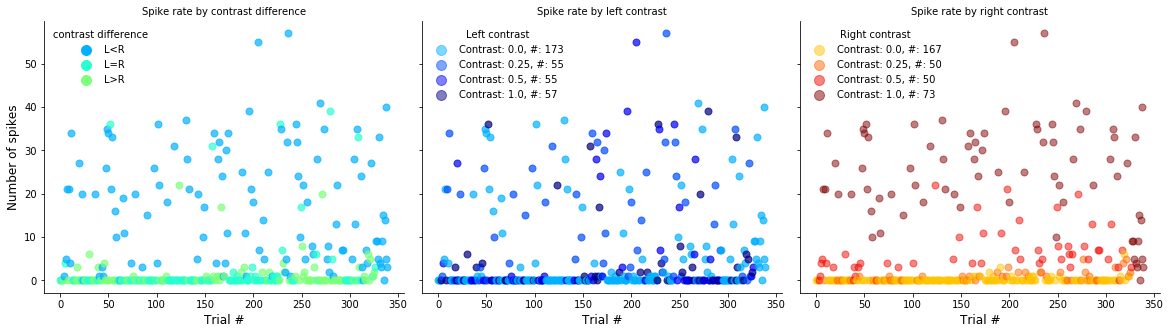

In [22]:
# Work with neuron 
chosen_neuron = 100 # 100 in the list of the whole 698 neurons
spikes_new = all_spikes[:,chosen_neuron] #print(np.mean(spikes_new))

# Subplot 1: How does #spikes change with contrast difference
color_list = plt.cm.jet(np.linspace(0.3,0.8,6))
f,ax=plt.subplots(1,3,figsize=(20,5),sharex=True, sharey=True)

for i in range(len(cdiff)):
    ax[0].plot(i,spikes_new[i],'o',color=color_list[int((cdiff[i]+1))],alpha=0.7,markersize=7)
    
ax[0].plot(np.inf,np.inf,'o',color=color_list[0],label='L<R',markersize=10)
ax[0].plot(np.inf,np.inf,'o',color=color_list[1],label='L=R',markersize=10)
ax[0].plot(np.inf,np.inf,'o',color=color_list[2],label='L>R',markersize=10)
ax[0].legend(loc='upper left',frameon=False,title='contrast difference'); 
ax[0].set_xlabel('Trial #'); ax[0].set_ylabel('Number of spikes')
ax[0].set_title('Spike rate by contrast difference')
sns.despine()

# Subplot 2: How does #spikes change with left contrast
color_list = plt.cm.jet(np.linspace(0.3,0,4))
contrast_list = np.unique(cL)
for itrial in range(len(cL)):
    idx = np.where(contrast_list == cL[itrial])[0][0]
    ax[1].plot(itrial, spikes_new[itrial],'o',color=color_list[idx],alpha=0.7,markersize=7)

for i in range(len(contrast_list)):
    ax[1].plot(np.inf,np.inf,'o',color=color_list[i],alpha=0.5,markersize=10,label=f'Contrast: {contrast_list[i]}, #: {np.sum(cL == contrast_list[i]):d}')

ax[1].legend(fontsize=10,frameon=False, title='Left contrast'); ax[1].set_xlabel('Trial #'); 
ax[1].set_title('Spike rate by left contrast');
sns.despine();
  
    
# #Subplot 3: How does #spikes change with right contrast
color_list = plt.cm.jet(np.linspace(0.7,1,4))
contrast_list = np.unique(cR)
for itrial in range(len(cR)):
    idx = np.where(contrast_list == cR[itrial])[0][0]
    ax[2].plot(itrial, spikes_new[itrial],'o',color=color_list[idx],alpha=0.5,markersize=7)

for i in range(len(contrast_list)):
    ax[2].plot(np.inf,np.inf,'o',color=color_list[i],alpha=0.5,markersize=10,label=f'Contrast: {contrast_list[i]}, #: {np.sum(cR == contrast_list[i]):d}')

ax[2].legend(fontsize=10,frameon=False,title='Right contrast'); ax[2].set_xlabel('Trial #'); 
ax[2].set_title('Spike rate by right contrast')
  
plt.subplots_adjust(wspace=0.05)
plt.show()
# # plt.savefig('Figures/Choice_of_stimulus.png')

In [23]:
''' 
Slice time based on stimulus onset, go cue and reward presentation time
'''
def time_slice(half_time_wind, dat):
    
    tslices = np.empty(shape=(2,),dtype='object')
    
    all_gocue_slice  = []
    all_rwd_slice = []
    
    gocue_time = (dat['gocue']*100+50).astype(int).flatten()
    rwd_time = (dat['feedback_time']*100+50).astype(int).flatten()
    
    for i in range(dat['spks'].shape[1]):
        gocue_slice = dat['spks'][:,i, gocue_time[i]-half_time_wind:gocue_time[i]+half_time_wind]
        all_gocue_slice.append(gocue_slice)
        
#         rwd_slice = dat['spks'][:,i,rwd_time[i]-half_time_wind: rwd_time[i]+half_time_wind]
#         pdb.set_trace()
#         all_rwd_slice.append(rwd_slice)

    all_gocue_slice = np.stack(all_gocue_slice, axis=1) # for session 11, output shape (698, 340, 40)
#     all_rwd_slice = np.stack(all_rwd_slice, axis=1)
    stimulus_onset_slice = dat['spks'][:,:,50-half_time_wind:50+half_time_wind] # for session 11, output shape (698, 340, 40)
    
    
    tslices[0] = stimulus_onset_slice; tslices[1] = all_gocue_slice #tslice[2] = all_rwd_slice
    
    return tslices

In [24]:
'''
Plot coupling weights for each brain region - coarse and fine (aggregated across sessions)
(a) Run GLM fitting across sessions
(b) Concatenate all coupling weights into one matrix
(c) Bar and color by brain region

'''

# Assign constants
d = 4
dummy_type = ['Right contrast','Go/NoGo']  #Add 'Left/Right' feedback later
half_time_wind = 20; to_slice = 1
which_idx = [2,1] #for right contrast, in tt, idx=2 is coupling, and for go-nogo, idx=1 is coupling


# Initialise storage variables
rr = np.empty(shape=(1000000,len(dummy_type))) # r2 of GLM fits
tt = np.empty(shape=(1000000,d+2,len(dummy_type))) # coefficients of GLM fits for all neurons
couple_session = np.empty(shape=(39,len(dummy_type)),dtype='object') # coupling to dummy variables stored by session

# Loop variables
kr = 0; kt = 0

for isession in tqdm(range(39)):
    dat = alldat[isession]
    ntrial = len(dat['response'])
    nneuron = len(dat['spks'])
    st1 = dat['contrast_right']
    dum = np.array([dat['response']*0, abs(dat['response'])>0]).T  #, dat['feedback_type']]).T #print(sum(dum))
    
    tslices = time_slice(half_time_wind,dat)
    
    for nn in range(nneuron):
        for idum in range(0,len(dum[0])):
            if to_slice:
                y1 = np.sum(tslices[idum],axis=2).T[:,nn]
            else:
                y1 = np.sum(dat['spks'],axis=2).T[:,nn] #Use this if not slicing based on trial epoch [stim onset, go cue, rwd]
            #pdb.set_trace()
            
            y2, th = predict_spike_counts_lnp(st1,dum[:,idum],y1,d,1)
            with np.errstate(divide='ignore'):
                rr_all = np.divide((y1-y2)**2,y1**2); rr_all[np.abs(rr_all)==np.inf]=0
            
            rr[kr,idum] = np.sqrt(np.mean(rr_all))
            tt[kt,:,idum] = th

        kr+=1;kt+=1
    

rr = rr[0:kr,:]; tt = tt[0:kr,:,:]
# f=plt.figure(figsize=(15,10))
# plt.plot(rr,'o'); plt.plot()
# plt.ylabel('Prediction error'); plt.xlabel('Neuron')



100%|██████████| 39/39 [33:12<00:00, 60.29s/it]


In [25]:
brain_area = []
start = 0
for isession in range(39):
#     print(isession)
    dat = alldat[isession]
    n_neuron = len(dat['spks'])
    brain_area.append(dat['brain_area'].tolist())
    
brain_area_all = np.array(brain_area)

import itertools
brain_area_all = list(itertools.chain(*brain_area))
brain_area_all = np.array(brain_area_all)
print(type(brain_area_all))

<class 'numpy.ndarray'>


##### Fit a Poisson GLM
Now we are ready to fit a Poisson GLM to predict stimulus (right contrast) or action (go or no-go). We fit the GLM over the time slice between stimulus onset (at 50s) and go-cue (between 800 and 1300 ms)

Next, we plot the coupling of neurons in each of the 39 sessions to stimulus and action. We also plot the neuron coupling weights by sorting. In some sessions, the coupling to stimuli and action are very similar (e.g., sessions 2, 5, 6), whereas in others, the coupling is quite different (e.g., sessions 7, 10, 11). This is likely because neurons recorded in those sessions are in distinct brain regions that encode stimulus and action with variable strength

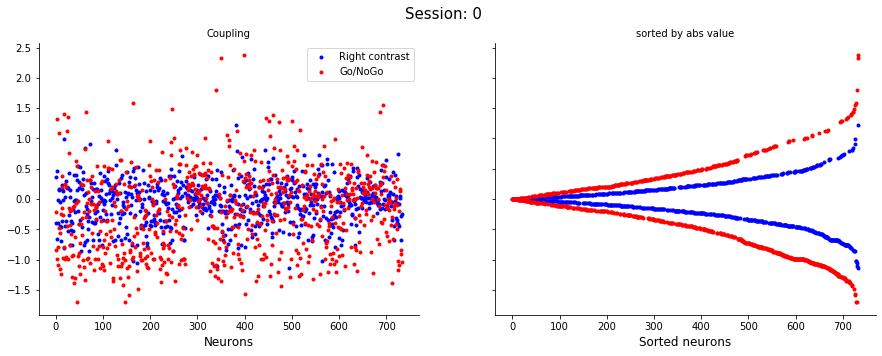

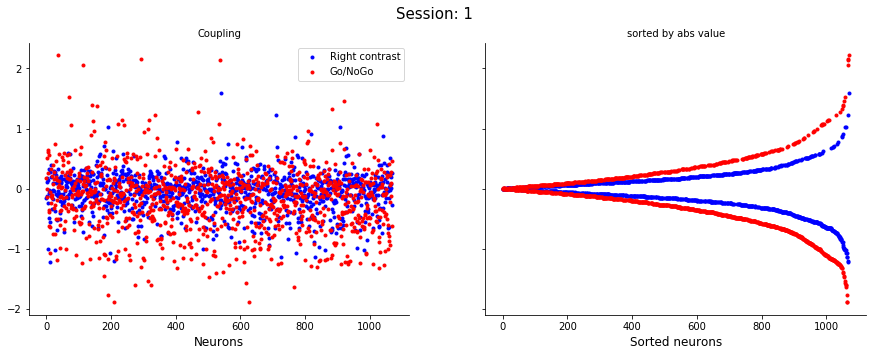

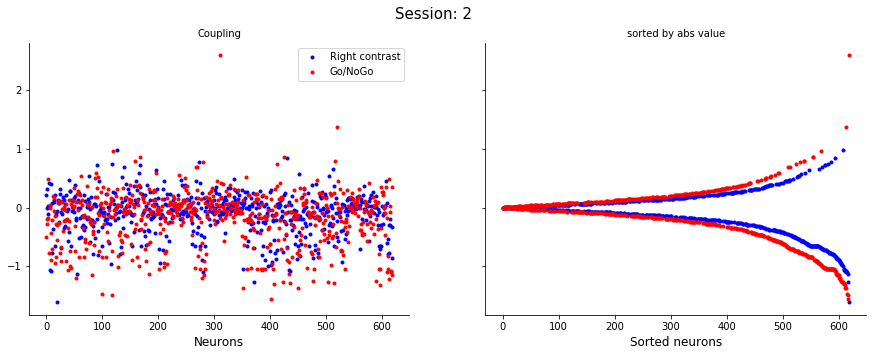

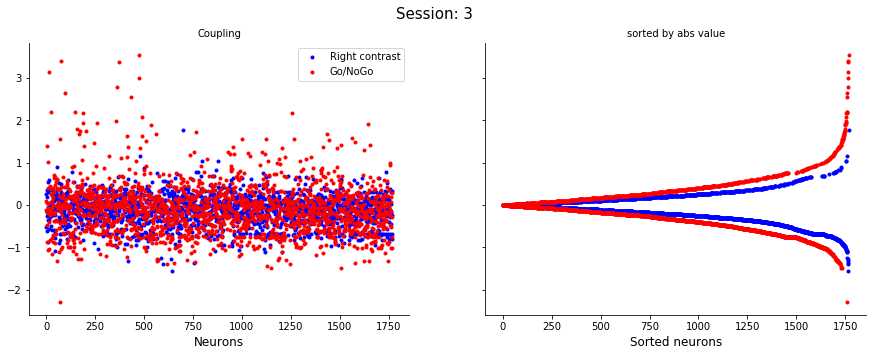

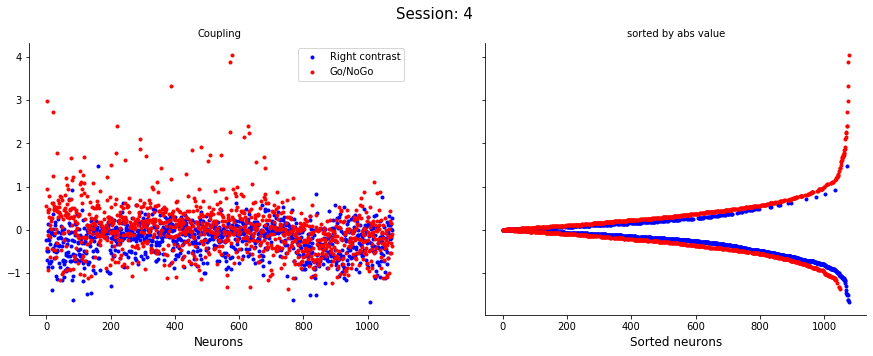

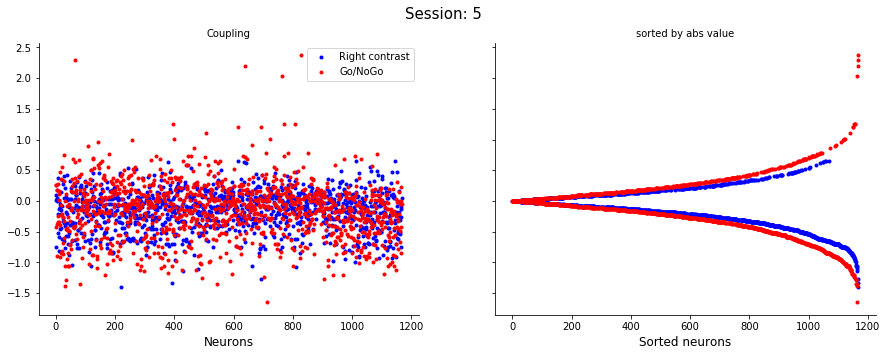

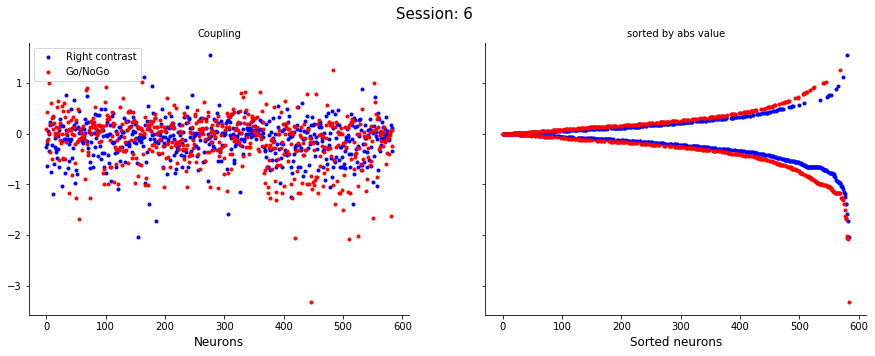

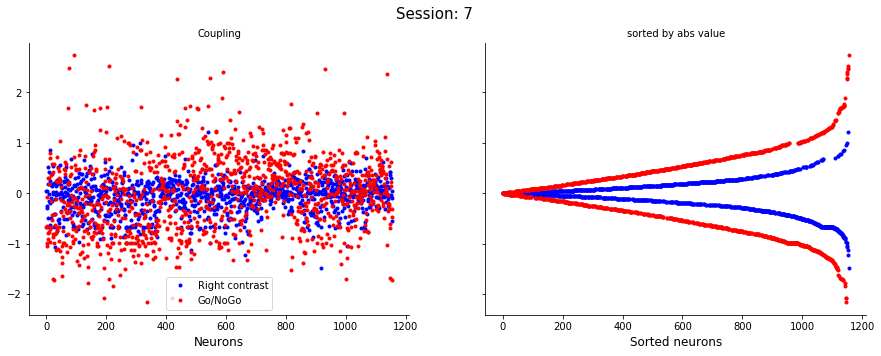

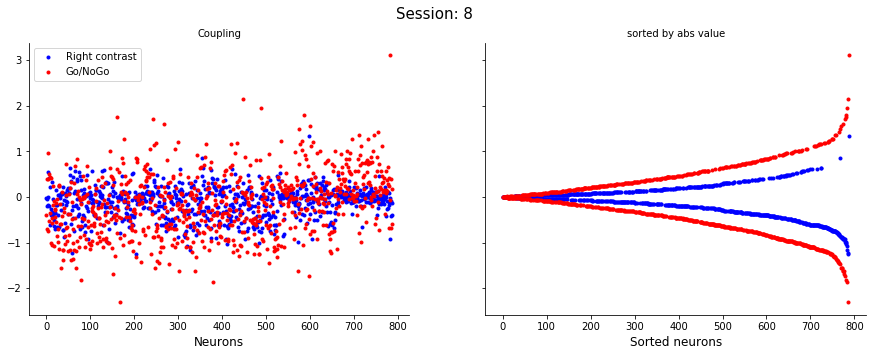

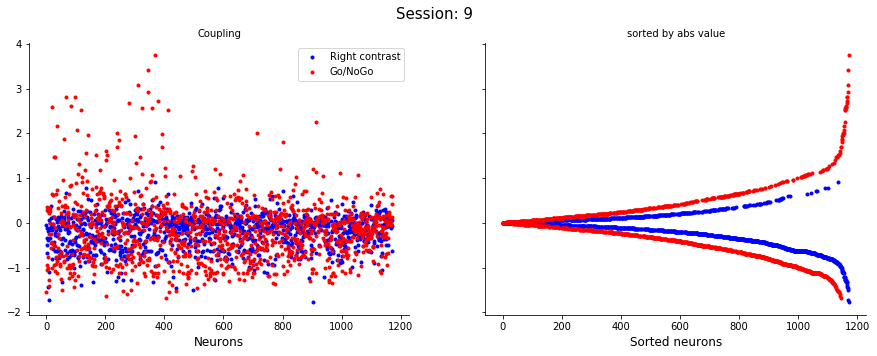

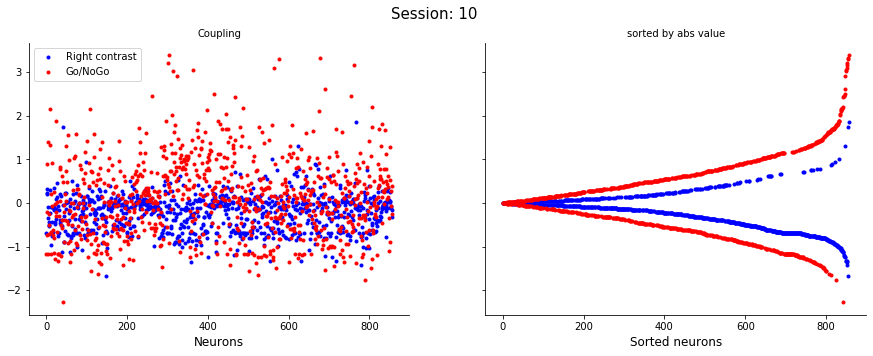

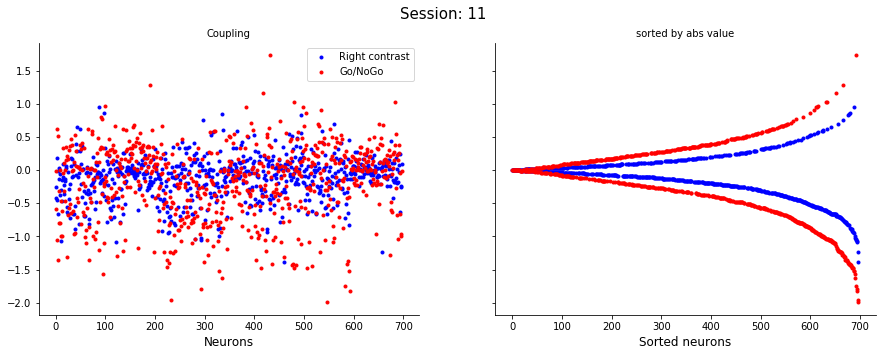

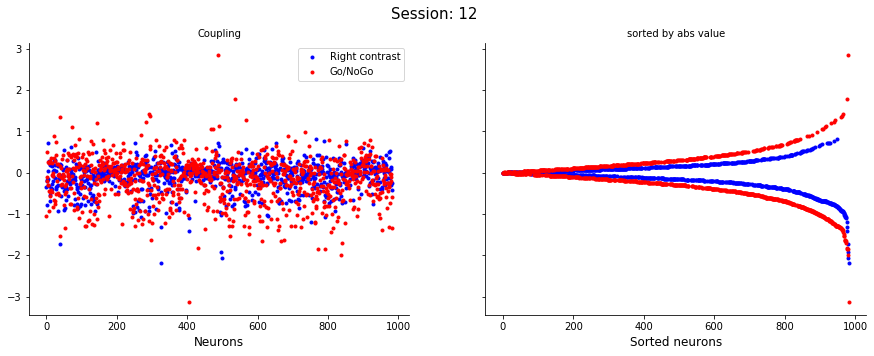

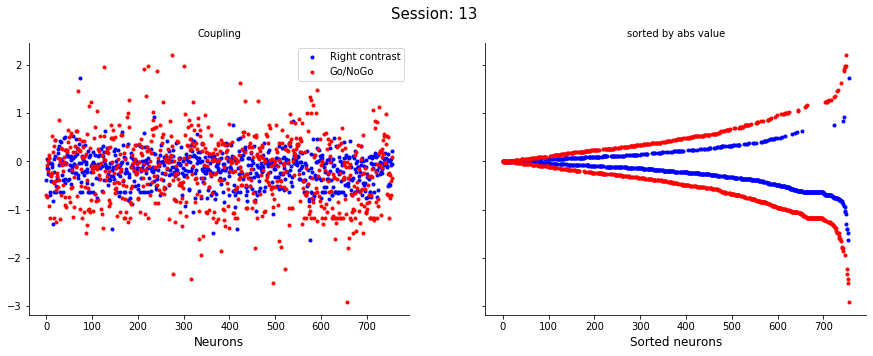

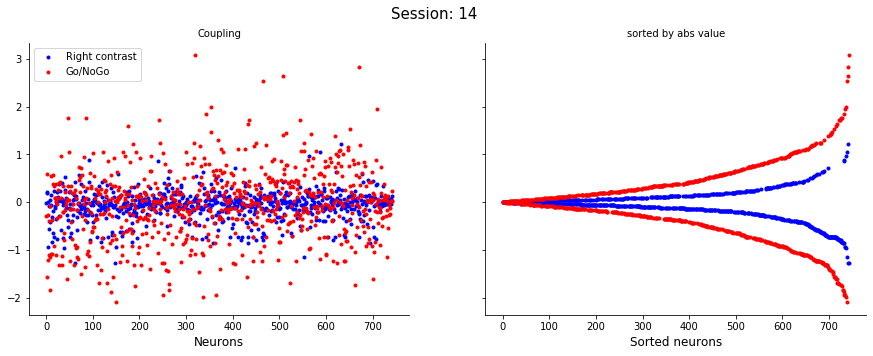

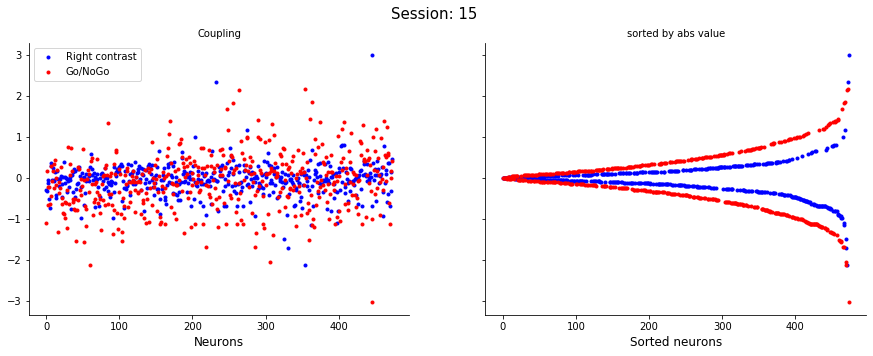

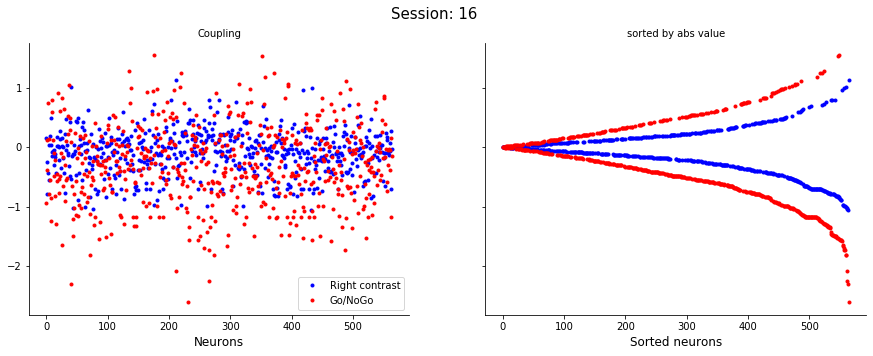

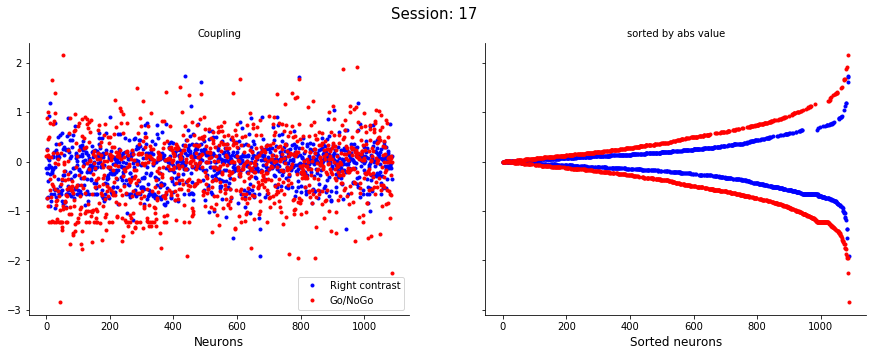

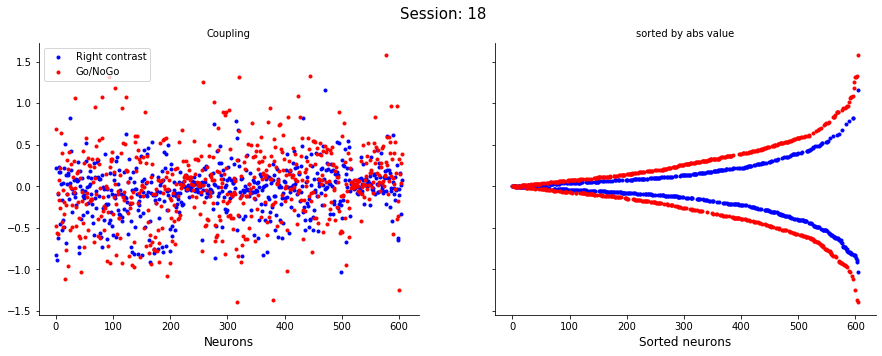

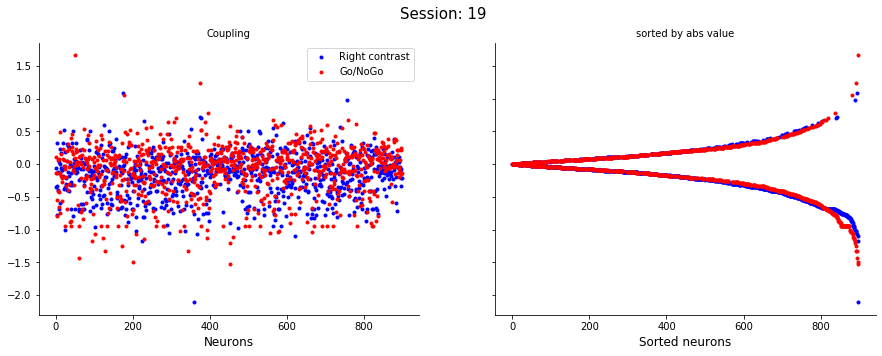

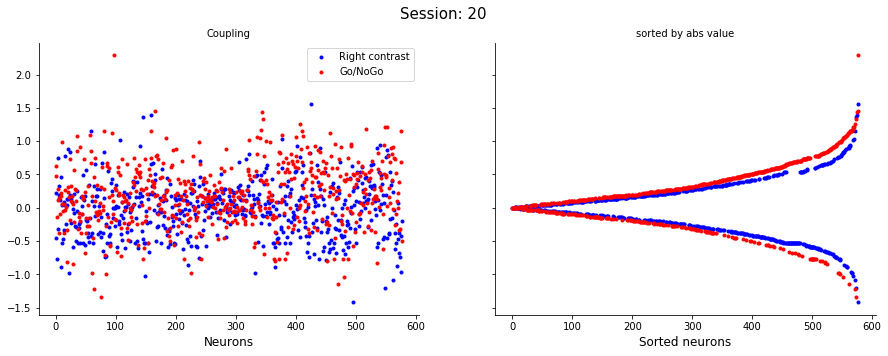

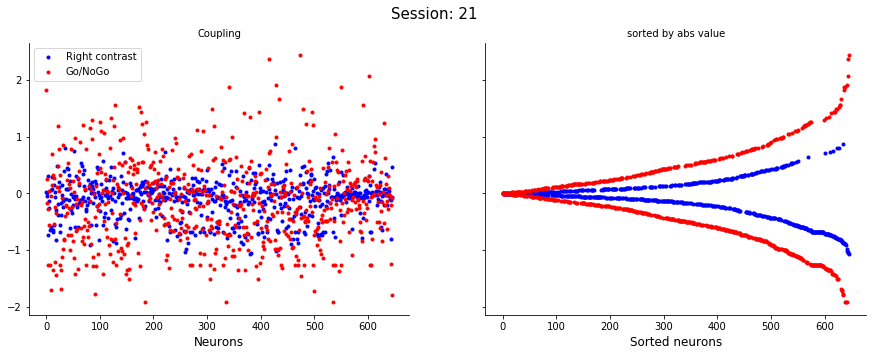

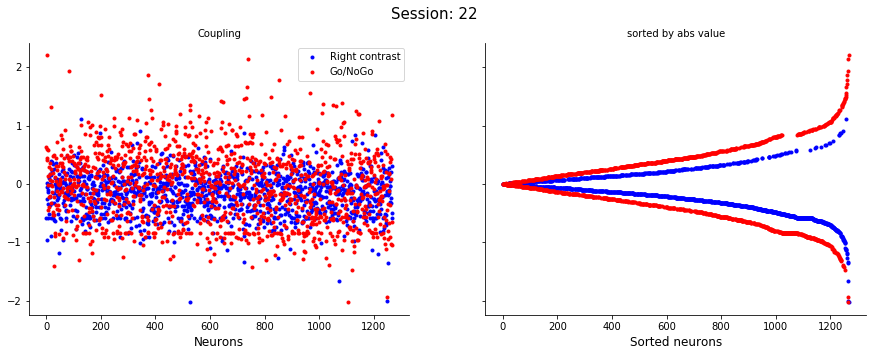

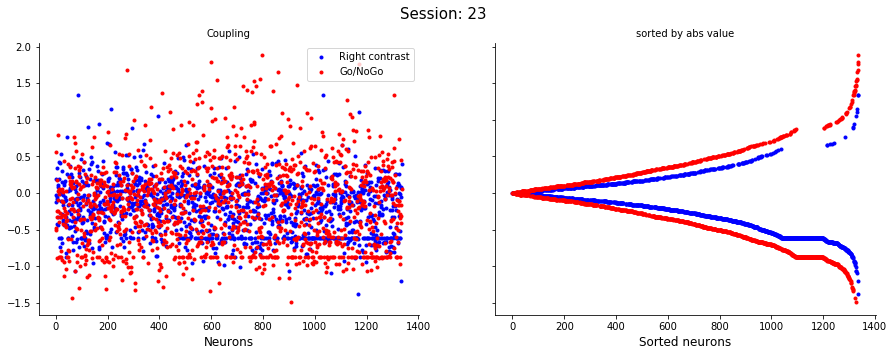

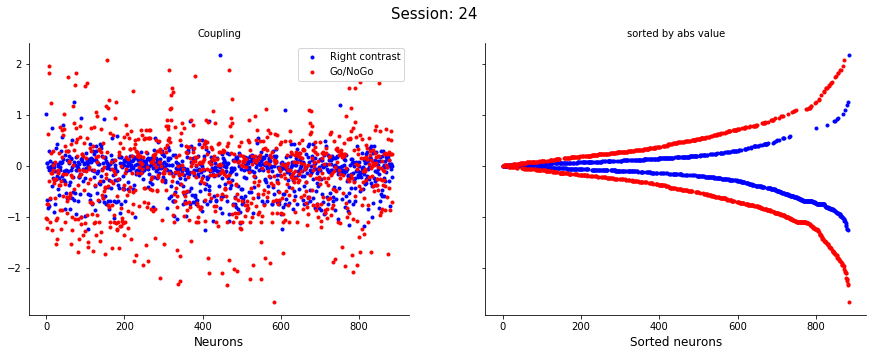

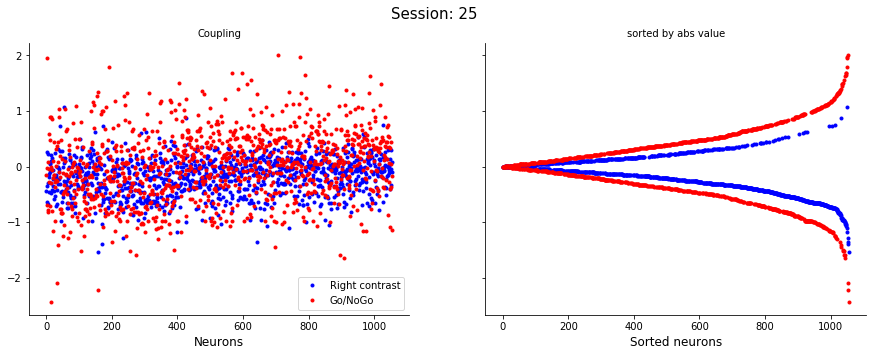

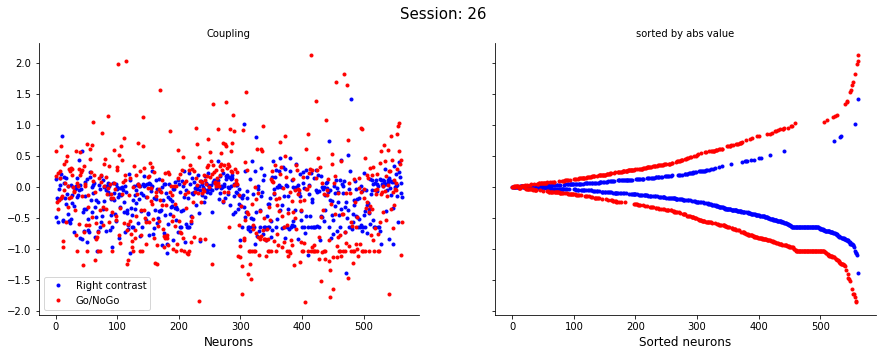

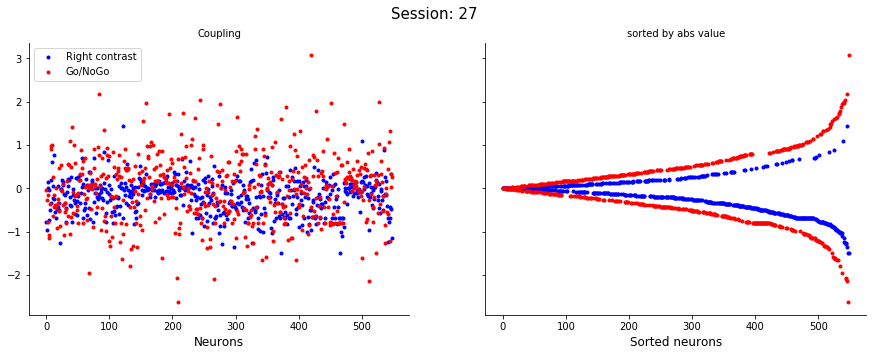

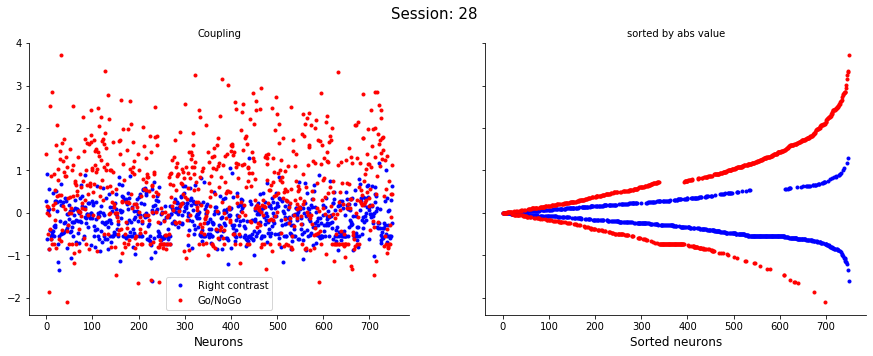

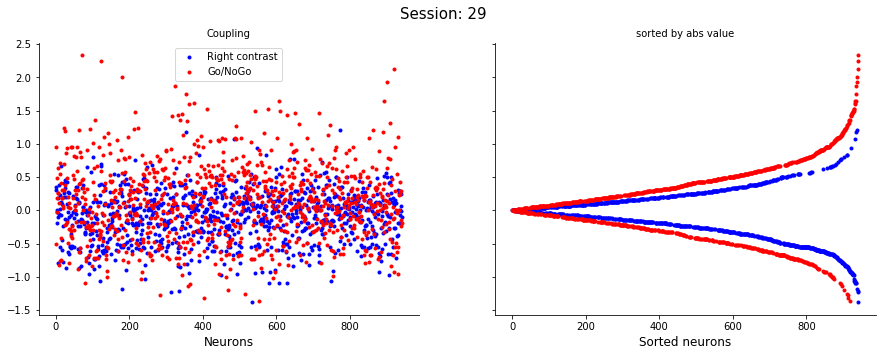

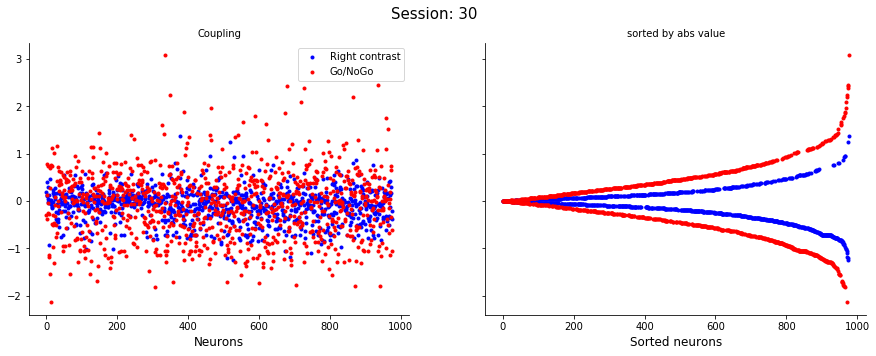

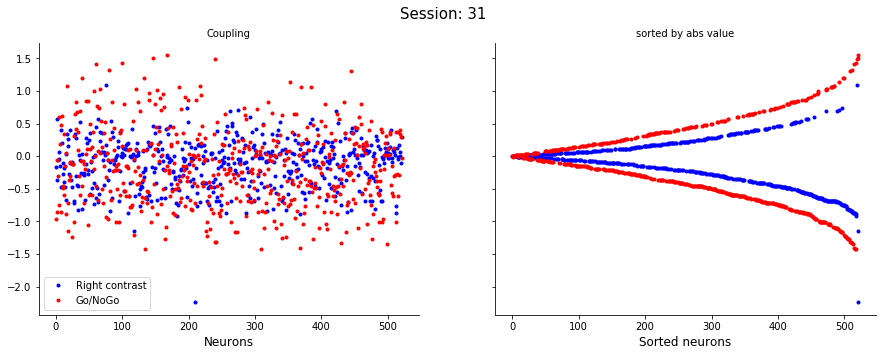

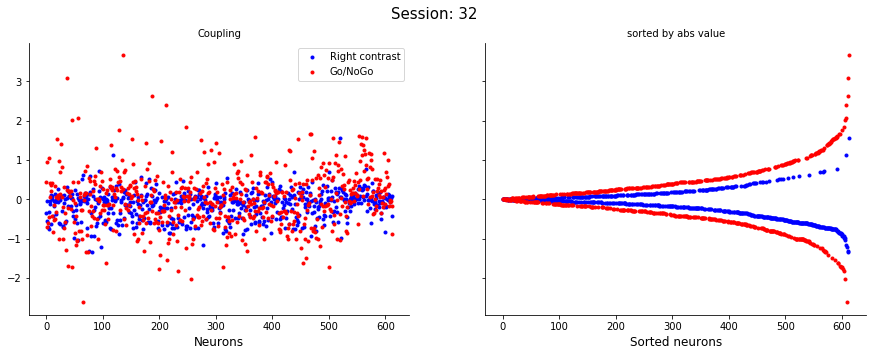

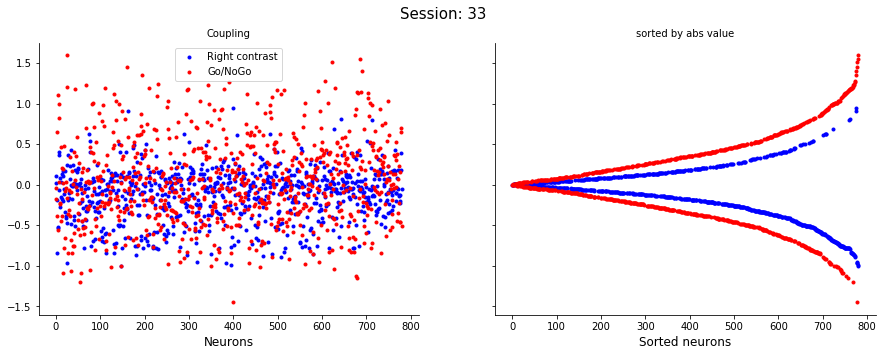

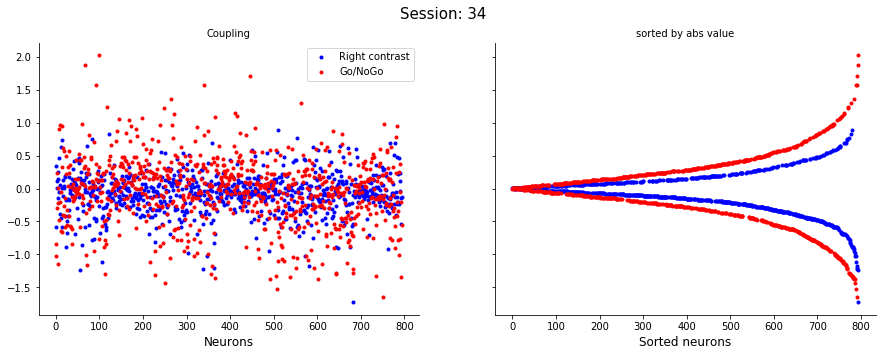

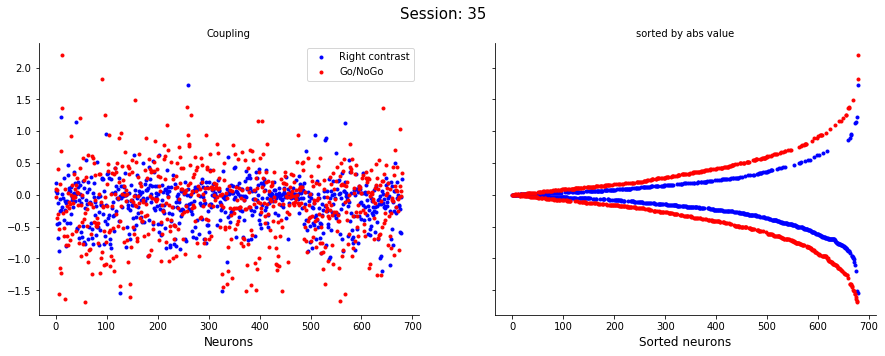

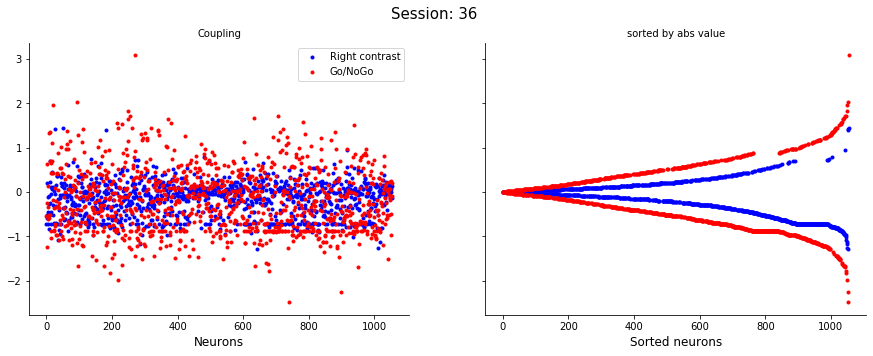

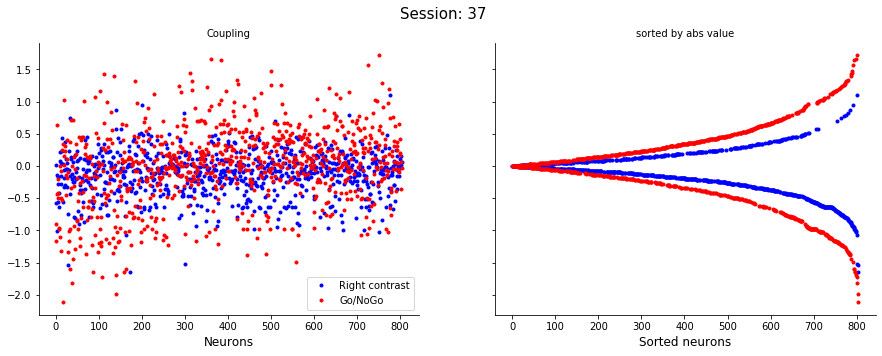

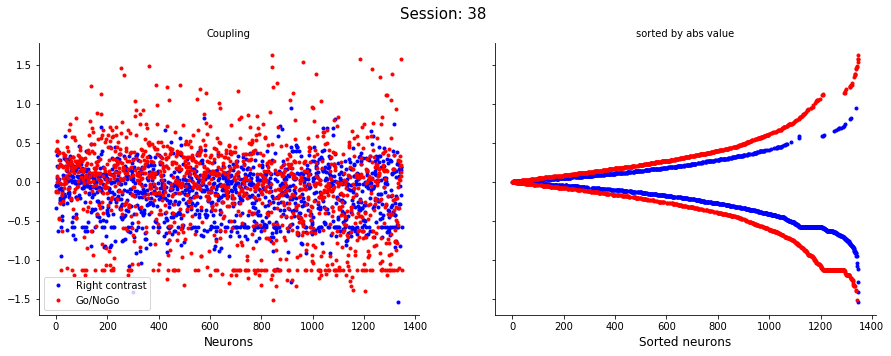

In [29]:
kt=0
cc, sort_idx, = [np.empty(shape=(39,2),dtype='object') for _ in range(2)]
cc_brain = np.empty(shape=(39,),dtype='object')

clist=['b','r']
for isession in range(39):
    dat = alldat[isession]
    nneuron = len(dat['spks'])
    
    f,ax = plt.subplots(1,2,figsize=(15,5),sharex=True, sharey=True)
    for idum in range(2):#range(len(dummy_type)):
        cc[isession,idum] = tt[kt:kt+nneuron,which_idx[idum],idum]
        cc_brain[isession] = brain_area_all[kt:kt+nneuron]
        
        sort_idx[isession,idum] = np.argsort(np.abs(cc[isession,idum]))
        
        
        ax[0].plot(cc[isession,idum],'.',color=clist[idum]); 
        ax[0].set_title('Coupling'); ax[0].set_xlabel('Neurons')
        
        ax[1].plot(cc[isession,idum][sort_idx[isession,idum]],'.',color=clist[idum]); 
        ax[1].set_xlabel('Sorted neurons'); ax[1].set_title('sorted by abs value'); plt.grid()
    
    ax[0].plot(np.inf,np.inf,'.',color=clist[0],label=dummy_type[0])
    ax[0].plot(np.inf,np.inf,'.',color=clist[1],label=dummy_type[1])
    ax[0].legend(); sns.despine()
    
    kt+=nneuron
    plt.suptitle(f'Session: {isession}')
    # plt.savefig(f'Figures/Time-slice coupling_session{isession:d}.png')
    





In [31]:
import pickle

f = open('coupling_matrix.pckl', 'wb')
pickle.dump([cc,cc_brain],f) #pickle.dump(rr,f); pickle.dump(cc,f); pickle.dump(cc_brain,f)
f.close()

f = open('coupling_matrix.pckl', 'rb')
obj1,obj2 = pickle.load(f)
f.close()

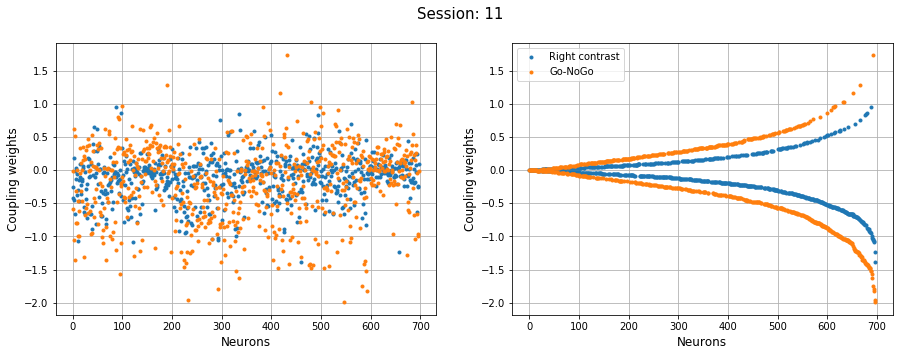

In [32]:
f = open('coupling_matrix.pckl', 'rb')
couplings, coupling_brain = pickle.load(f)

which_session = 11
f = plt.figure(figsize=(15,5))
# To plot couplings to session 11
plt.subplot(1,2,1); plt.plot(couplings[which_session,0],'.',label='Right contrast'); plt.grid()
plt.plot(couplings[which_session,1],'.',label='Go-NoGo'); plt.xlabel('Neurons'); plt.ylabel('Coupling weights')

sort_couplings = np.argsort(np.abs(couplings[which_session,0]))
plt.subplot(1,2,2); plt.plot(couplings[which_session,0][sort_couplings],'.',label='Right contrast'); plt.grid();plt.xlabel('Neurons')

sort_couplings = np.argsort(np.abs(couplings[which_session,1]))
plt.plot(couplings[which_session,1][sort_couplings],'.',label='Go-NoGo'); plt.xlabel('Neurons'); plt.ylabel('Coupling weights')

plt.legend()
plt.suptitle(f'Session: {which_session:d}'); plt.show()


#### Neural coupling by brain region
The previous analysis is a decent first pass of how neurons in each session encode stimulus and action, but that analysis does not tell us anything about which brain regions encode stimulus and action strongly. 

In the next few plots, we plot the absolute value of the coupling weights by brain regions - first, by a fine dissection of brain regions and next by a coarser dissection

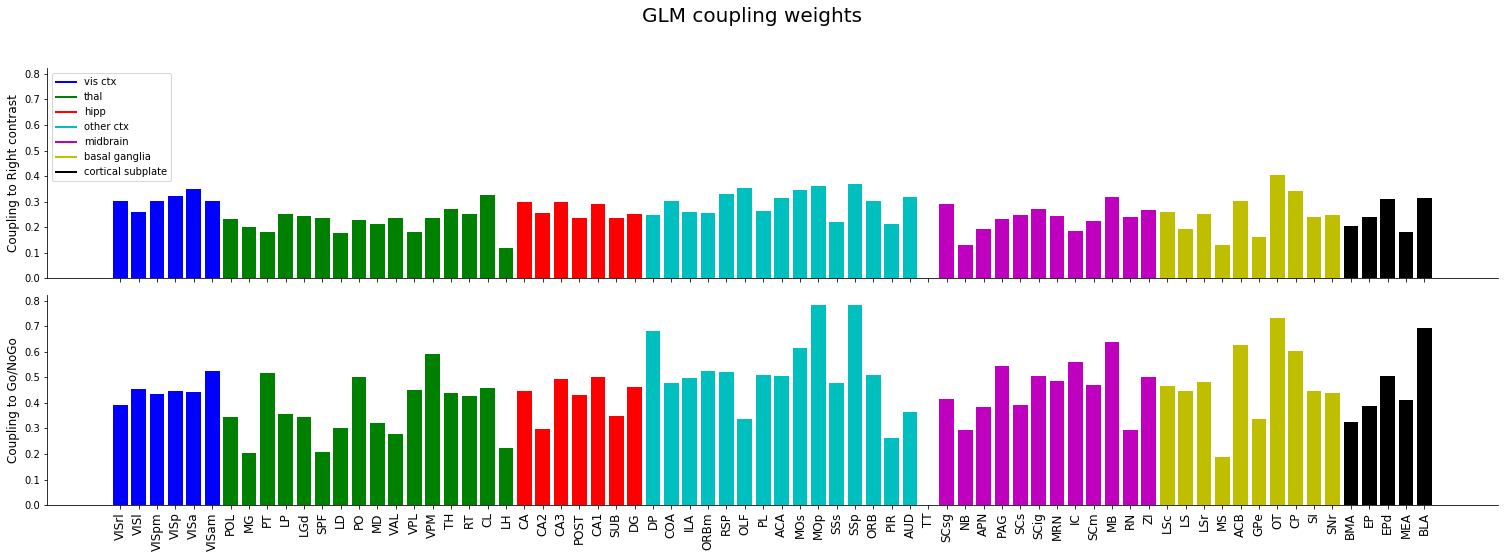

In [39]:

regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]

sorted_brain_groups = [ ['VISrl', 'VISl', 'VISpm', 'VISp', 'VISa', 'VISam'],
['POL', 'MG', 'PT', 'LP', 'LGd', 'SPF', 'LD', 'PO', 'MD', 'VAL', 'VPL', 'VPM', 'TH','RT', 'CL', 'LH'],
['CA', 'CA2', 'CA3', 'POST', 'CA1', 'SUB', 'DG'],
['DP', 'COA', 'ILA', 'ORBm', 'RSP', 'OLF', 'PL', 'ACA', 'MOs', 'MOp', 'SSs', 'SSp','ORB', 'PIR', 'AUD', ' TT'],
['SCsg', 'NB', 'APN', 'PAG', 'SCs', 'SCig', 'MRN', 'IC', 'SCm', 'MB', 'RN', 'ZI'],
['LSc', 'LS', 'LSr', 'MS', 'ACB', 'GPe', 'OT', 'CP', 'SI', 'SNr'],
['BMA', 'EP', 'EPd', 'MEA', 'BLA'] ]


all_brain_groups = []; all_area = []
for sublist in range(len(sorted_brain_groups)):
    for item in range(len(sorted_brain_groups[sublist])):
        all_brain_groups.append(sorted_brain_groups[sublist][item])
        all_area.append(sublist)

        
# col_list = ['blue','green','red','cyan','magenta','yellow','black']
col_list=['b', 'g', 'r', 'c', 'm', 'y', 'k']
which_color=1
f,ax = plt.subplots(2,1,figsize=(21,7),sharex=True, sharey=True)

for idum in range(2):
    for ib in range(len(all_brain_groups)):
        which_color=all_area[ib]
        idx_by_brain=brain_area_all == all_brain_groups[ib]
        ax[idum]
        try:
            if np.sum(idx_by_brain)==0:
                yy=0
            else:
                yy=np.mean(np.abs(tt[idx_by_brain,which_idx[idum],idum]))
        except:
            pdb.set_trace()
        ax[idum].set_ylabel(f'Coupling to {dummy_type[idum]}')
        ax[idum].bar(ib, yy,color=col_list[which_color])
        ax[idum].set_xticks(range(len(all_brain_groups)))
        ax[idum].set_xticklabels(all_brain_groups,rotation='vertical',fontsize=12); sns.despine();

for icol in range(len(col_list)):
    ax[0].plot(np.inf,np.inf,color=col_list[icol],linewidth=2,label=regions[icol])
    ax[0].legend(loc='upper left')
plt.suptitle('GLM coupling weights',y=1.1,fontsize=20); plt.tight_layout()
# plt.savefig('Figures/time-slice fine_brain_regions.png')
plt.show()

In general, the coupling weights to stimulus contrast are lower than those to action across all brain regions

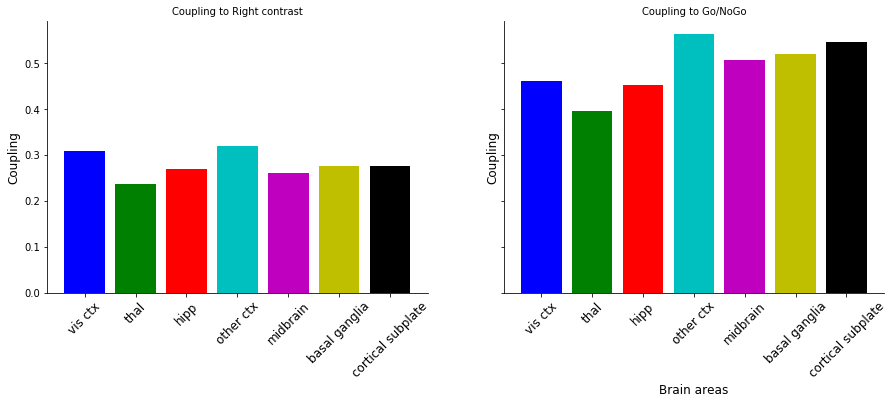

In [48]:
'''
(D) Plot mean weights by bigger brain groups (cell after next)
'''
nareas = len(regions)-1 
NN = len(brain_area_all) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(brain_area_all, sorted_brain_groups[j])] = j # assign a number to each region

yy=np.zeros(shape=(nareas,len(dummy_type)))
f, ax=plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
for idum in range(2):#range(len(dummy_type)):
    ax[idum]
    for j in range(nareas): 
        try:
            yy[j,idum] = np.mean(np.abs(tt[barea==j,which_idx[idum],idum]))
            ax[idum].bar(j,yy[j,idum], color=col_list[j],label=regions[j])

        except:
            pdb.set_trace()

        ax[idum].set_title(f'Coupling to {dummy_type[idum]}'); sns.despine()
        ax[idum].set_ylabel('Coupling'); plt.xlabel('Brain areas')

    ax[idum].set_xticks(range(len(regions)-1));
    ax[idum].set_xticklabels(regions[:-1],rotation=45,fontsize=12)
# plt.savefig('Figures/time-slice_coarse_regions.png')  


#### Main result: Normalized coupling weights
In order to compare coupling weights of each brain region, we normalized the weights by the total weights for each stimulus across *all* brain regions. This normalization helps us compare coupling to either stimulus or action by placing their magnitudes on equal footing

We see that visual cortex (as well as thalamus and hippocampus to some extent) have higher normalized coupling to visual stimulus contrast than to action (go vs no-go). In contrast, both midbrain and basal ganglia have higher normalized coupling to the action as compared to the stimulus contrast

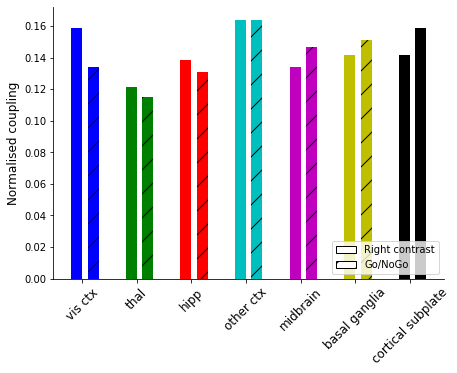

In [47]:
hat = ['','/']
yy_norm = np.zeros_like(yy)
f,ax=plt.subplots(1,1,figsize=(7,5))
for idum in range(2):
    yy_norm[:,idum] = yy[:,idum]/np.sum(yy[:,idum])
    ax.bar(np.inf,np.inf,hatch=hat[idum],edgecolor='black',color='white', label=dummy_type[idum])
    for j in range(nareas):
        ax.bar(j-0.1+0.3*idum,yy_norm[j,idum],width=0.2,color=col_list[j],hatch=hat[idum])
    plt.xticks(range(len(regions)-1),regions[:-1],rotation=45,fontsize=12);
    sns.despine()
plt.legend(loc='lower right'); plt.ylabel('Normalised coupling')
# plt.savefig('Figures/time-slice_coarse_regions_compare.png')
plt.show();  

### Supplementary:
* Goodness of fits $r^2$ in the Poisson GLM: 
We calculated how well the Poisson GLM predicted the neural activity and determined the $r^2$ of predicted spike counts (we call it pseudo $r^2$ since we removed any neurons for which spike count were zero). Both thalamus and mid-brain had high $r^2$, although I didn't analyze what are the actual distributions of spike counts in the neurons in this regions. Or if there is a correlation between the average spike count in a brain region and the goodness of fit

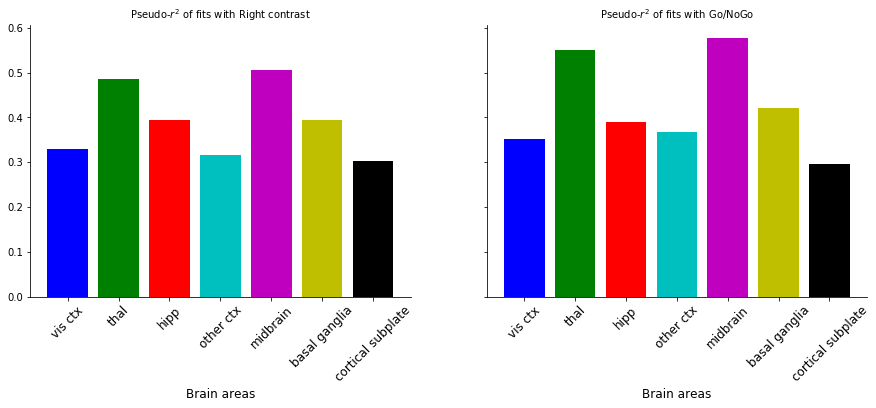

In [74]:
'''
Plot r^2 of fits for each brain region
'''
f,ax=plt.subplots(1,2,figsize=(15,5),sharex=True, sharey=True)
for idum in range(len(dummy_type)):
    for j in range(nareas): 
        try:
            yy = np.mean((rr[barea==j,idum]))
            ax[idum].bar(j,yy, color=col_list[j],label=regions[j]);
            sns.despine();
        except:
            pdb.set_trace()

        ax[idum].set_title(f'Pseudo-$r^2$ of fits with {dummy_type[idum]}')
        ax[idum].set_xlabel('Brain areas')
        ax[idum].set_xticks(range(len(regions)-1))
        ax[idum].set_xticklabels(regions[:-1],rotation=45,fontsize=12)



* How many history points are needed for a reasonable prediction?
In all our previous analyses, we used a history of 10 past stimuli to predict spike count. We chose that based on some preliminary analyses as shown below. Around 10 history points, the train and test error (specifically for the right contrast) starts to increase starkly

In [54]:
'''
1. Divide data into train-test. Preserve chronology!
2. Encode 
    (a) contrast difference, 
    (b) right contrast in Poisson GLM on train data
3. Test accuracy on test data.
    (a) MSE
    (b) R^2

'''
# Initialise variables for Poisson GLM fitting
L1_penalty = 20

# Define types of stimuli
stim_type =['Contrast difference','Left contrast','Right contrast']

# Get index of train and test data
idx_train = range(0,int(len(cdiff)*0.75)); idx_test = range(int(len(cdiff)*0.75), len(cdiff))

# Divide stimuli into train and test 
stim_train = np.empty(shape=(len(idx_train),len(stim_type)))
stim_test = np.empty(shape=(len(idx_test),len(stim_type)))

stim_train[:,0] = cdiff[idx_train]; stim_test[:,0] = cdiff[idx_test] # Stimulus 1: Contrast difference
stim_train[:,1] = cL[idx_train]; stim_test[:,1] = cL[idx_test]  # Stimulus 2: Right contrast
stim_train[:,2] = cR[idx_train]; stim_test[:,2] = cR[idx_test]  # Stimulus 2: Right contrast
dummy_train = abs(dat['response'][idx_train])>0

# Divide spikes into train and test
spikes_train = all_spikes[idx_train,:]; spikes_train = spikes_train[:, vis_neurons_thresh]
spikes_test = all_spikes[idx_test,:]; spikes_test = spikes_test[:, vis_neurons_thresh]
dummy_test = abs(dat['response'][idx_test])>0

# List d parameters
d_list = range(2,30,2)

# Initialize variable for each L1 penalty
ytrain = np.empty(shape=(len(idx_train),len(stim_type),len(d_list),len(vis_neurons_thresh)))
ytest = np.empty(shape=(len(idx_test),len(stim_type),len(d_list),len(vis_neurons_thresh)))
train_accuracy, test_accuracy = [np.empty(shape=(len(stim_type),len(d_list),len(vis_neurons_thresh))) for _ in range(2)]

# Initialize theta_d to store temporal filters for d=10 values
theta_d = np.empty(shape=(11,len(stim_type),len(vis_neurons_thresh)))

# Fit to training data and evaluate on test data
for chosen_neuron in tqdm(range(len(vis_neurons_thresh))):
#     print(vis_neurons_thresh[chosen_neuron])
    for d1 in range(len(d_list)):
        for istim in range(len(stim_type)):
            ytrain[:,istim,d1,chosen_neuron], theta = predict_spike_counts_lnp(
                stim_train[:,istim], dummy_train, spikes_train[:,chosen_neuron],d_list[d1],L1_penalty)
            ytest[:,istim,d1,chosen_neuron],_ = predict_spike_counts_lnp(
                stim_test[:,istim], dummy_test, spikes_test[:,chosen_neuron],d_list[d1],L1_penalty,theta)

            # Evaluate 'accuracy' on train and test data
            train_accuracy[istim,d1,chosen_neuron] = np.mean(
                np.divide(((ytrain[:,istim,d1,chosen_neuron] - spikes_train[:,chosen_neuron])**2), ytrain[:,istim,d1,chosen_neuron])
            )
            test_accuracy[istim,d1,chosen_neuron] = np.mean(
                np.divide(((ytest[:,istim,d1,chosen_neuron] - spikes_test[:,chosen_neuron])**2), ytest[:,istim,d1,chosen_neuron])
            )
            
           #save theta for d=9
            if d_list[d1]==9:
                theta_d[:,istim,chosen_neuron] = theta;  



100%|██████████| 28/28 [01:13<00:00,  2.68s/it]


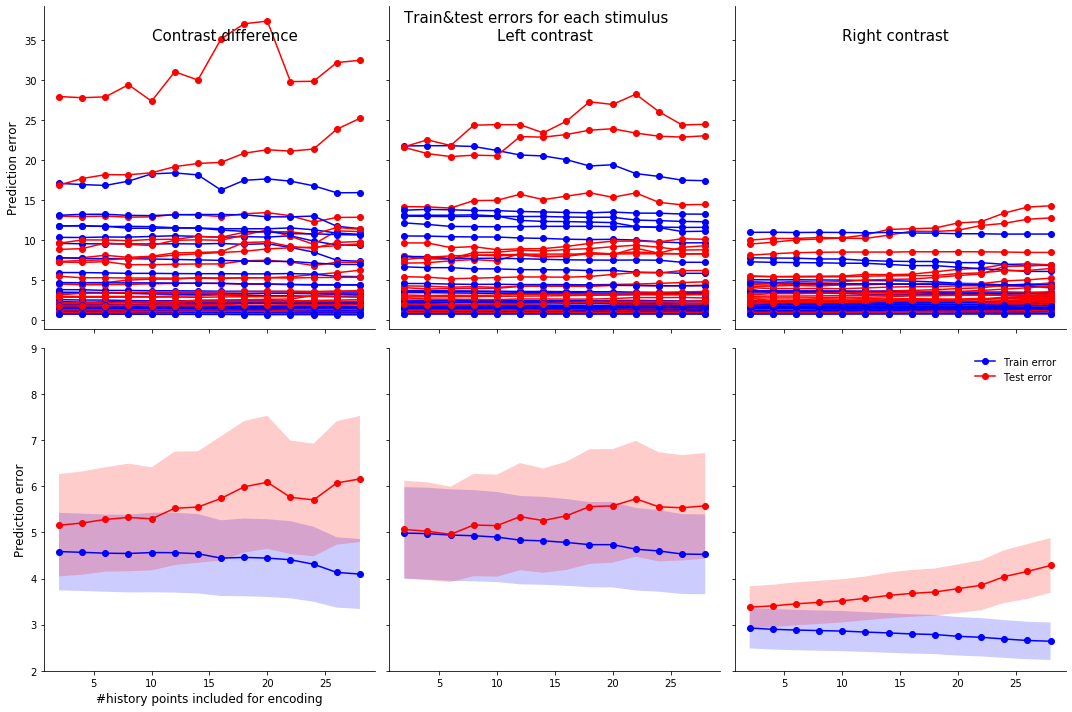

In [72]:
# Plot train-test accuracy for each neuron
f,ax=plt.subplots(2,3,figsize=(15,10),sharex=True, sharey='row')
for istim in range(len(stim_type)):
    for which_neuron in range(len(vis_neurons_thresh)):
        ax[0,istim].plot(d_list, train_accuracy[istim,:,which_neuron],'o-b',label='Train accuracy')
        ax[0,istim].plot(d_list,test_accuracy[istim,:,which_neuron],'o-r',label='Test accuracy')
    ax[0,istim].text(10,35,stim_type[istim],size=15); sns.despine()
ax[1,0].set_xlabel('#history points included for encoding'); 
ax[0,0].set_ylabel('Prediction error');ax[1,0].set_ylabel('Prediction error');

# Plot average train-test accuracy
for istim in range(len(stim_type)):
    
    yy_train = np.mean(train_accuracy[istim,:,:],axis=1)
    yy_test = np.mean(test_accuracy[istim,:,:],axis=1)
    err_train = np.std(train_accuracy[istim,:,:],axis=1)/np.sqrt(len(train_accuracy[istim,0,]))
    err_test = np.std(test_accuracy[istim,:,:],axis=1)/np.sqrt(len(test_accuracy[istim,0,]))
    
    ax[1,istim].plot(d_list,yy_train,'o-b',label='Train error')
    ax[1,istim].plot(d_list,yy_test,'o-r',label='Test error')
    ax[1,istim].fill_between(d_list,yy_train-err_train,yy_train+err_train,facecolor='b',alpha=0.2)
    ax[1,istim].fill_between(d_list,yy_test-err_test,yy_test+err_test,facecolor='r',alpha=0.2)
    
    ax[1,istim].set_ylim([2,9])
    
plt.suptitle('Train&test errors for each stimulus'); plt.tight_layout();
plt.legend(frameon=False)
# plt.savefig('Figures/Test-train accuracy.png')
plt.show()
